In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate the model to predict Pe

In [2]:
d = pd.read_excel("data/NASCseq.xlsx")
d = d[(d["CellLine"] == "K562") & (d["s4U"] == 0) & (d["Layout"] == "PE")]
print("Number of control cells:", len(d))

Number of control cells: 39


In [5]:
array = []
for run, cell in d[["Run", "Cell"]].values:
    path = "results/mismatch/ratio/%s/%s.tsv" % (run, cell)
    m = pd.read_csv(path, sep="\t", header=0, index_col=0)
    m = m[["-" not in t for t in m.index]]
    s = m["Ratio.NoSNP"]
    s.name = cell
    array.append(s)
m = pd.DataFrame(array)
m.index.name = "Cell"

In [7]:
mtypes = []
bases = "ACGT"
for b1 in "ACGT":
    for b2 in "ACGT":
        if b1 != b2:
            mtypes.append("%s%s" % (b1, b2))

Type	K	R
AC	0.9392	0.0393
AG	1.4593	0.9654
AT	1.265	0.4939
CA	0.9182	0.1876
CG	3.5458	0.6465
CT	0.9376	0.9041
GA	1.0492	0.936
GC	2.3969	0.6043
GT	0.5966	0.1586
TA	0.8509	0.5232
TC	1.0	1.0
TG	0.576	0.052


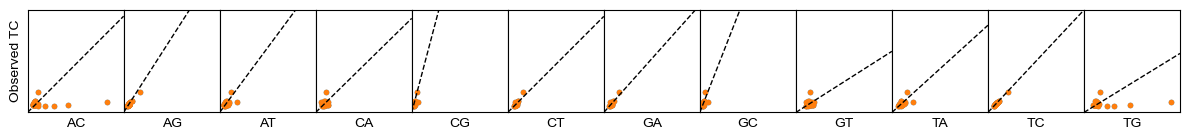

In [8]:
lim = m.max().max() * 1.1
fig, axs = plt.subplots(1, 12, figsize=(12, 1.5), sharex=True, sharey=True, gridspec_kw=dict(wspace=0))
rows = []
print("Type\tK\tR")
for i, mtype in enumerate(mtypes):
    ax = axs[i]
    plt.sca(ax)
    xs = m[mtype]
    ys = m["TC"]
    flags = (xs > lim * 0) & (ys > lim * 0)
    xs1 = xs[flags]
    ys1 = ys[flags]
    r = np.corrcoef(xs1, ys1)[0][1]
    k = np.e ** ((sum(np.log(ys1)) - sum(np.log(xs1))) / len(xs1))
    print(mtype, round(k, 4), round(r, 4),sep="\t")
    rows.append([mtype, k, r])
    plt.scatter(xs, ys, marker=".")
    plt.scatter(xs1, ys1, marker=".")
    plt.plot([0, lim], [0, lim * k], lw=1, ls="--", color="black")
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(mtype)
    if i == 0:
        plt.ylabel("Observed TC")
plt.tight_layout()
plt.show()

In [9]:
model = pd.DataFrame(rows, columns=["Type", "K", "R"])
model = model[(model["Type"] != "TC") & (model["R"] >= 0.8)]
model["W"] = model["R"] / model["R"].sum()
model.to_csv("reports/Estimate.Pe.Model.K562.PE.tsv", sep="\t", index=False)
print("Model:")
print(model)

Model:
  Type         K         R         W
1   AG  1.459302  0.965415  0.344117
5   CT  0.937641  0.904107  0.322265
6   GA  1.049155  0.935958  0.333618


In [10]:
array = []
for t, k, r, w in model.values:
    array.append(m[t] * k * w)
m1 = m.copy()
m1["Pe"] = pd.DataFrame(array).sum(axis=0)

Custom strategy
K: 0.9979, R: 0.9638


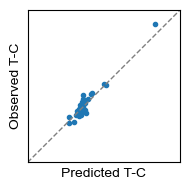

NASC-seq strategy
K: 0.9900, R: 0.9254


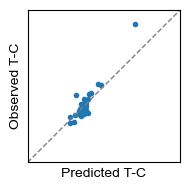

GRAND-SLAM strategy
K: 0.6761, R: 0.1396


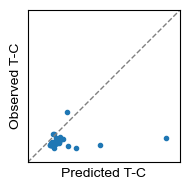

In [11]:
params = [
    ["Custom strategy", m1["Pe"], m1["TC"]],
    ["NASC-seq strategy", (m1["CT"] + m1["GA"]) / 2, m1["TC"]],
    ["GRAND-SLAM strategy", ((m1["TA"] + m1["TG"]) / 2), m1["TC"]]
]
for name, xs, ys in params:
    print(name)
    lim = max(max(xs), max(ys)) * 1.1
    r = np.corrcoef(xs, ys)[0][1]
    k = np.e ** ((sum(np.log(ys)) - sum(np.log(xs))) / len(xs))
    print("K: %.4f, R: %.4f" % (k, r))
    plt.figure(figsize=(2, 2))
    plt.scatter(xs, ys, marker=".")
    plt.plot([0, lim], [0, lim], lw=1, color="grey", ls="--")
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Predicted T-C")
    plt.ylabel("Observed T-C")
    plt.tight_layout()
    plt.show()
    plt.close()